## Preprocessing Stereo-seq data
This notebook walks through the processing of preparing spatial transcriptomics data to be used to infer differentiation trajectories with SOCS. This notebook specifically processes samples of developing mouse lung, obtained from the Mouse Organogenesis Spatial Transcriptomics Atlas (MOSTA), but can be easily adapted to process other samples.

First, we'll import necessary python modules.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import anndata as ad
import scipy as sp
import scanpy as sc
import squidpy as sq
import sklearn
import copy
import pickle
import json
import scipy.spatial as scisp
import seaborn as sns
from stot_analysis.analysis import neighborhood_n_layers

//broad/clearylab/Users/Peter/anaconda3/envs/myEnv/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
2024-10-30 14:34:14.015428: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-30 14:34:14.017358: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-30 14:34:14.024016: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-30 14:34:14.045335: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT fact

We'll load in the unprocessed samples, which are stored as spots-by-genes count tables (with matched spatial location tables) in AnnData data structures.

In [2]:
adata_1 = sc.read_h5ad('lung_14_2_raw.h5ad')
adata_2 = sc.read_h5ad('lung_15_4_raw.h5ad')
#Version of the spatial coordinates for consistent visualization with pyplot and squidpy
adata_1.obsm['spatial_sq'] = copy.deepcopy(adata_1.obsm['spatial']) 
adata_1.obsm['spatial_sq'][:,1] = -adata_1.obsm['spatial_sq'][:,1]
adata_2.obsm['spatial_sq'] = copy.deepcopy(adata_2.obsm['spatial'])
adata_2.obsm['spatial_sq'][:,1] = -adata_2.obsm['spatial_sq'][:,1]

We can visualize the sample in space with a scatter plot of the spot locations:

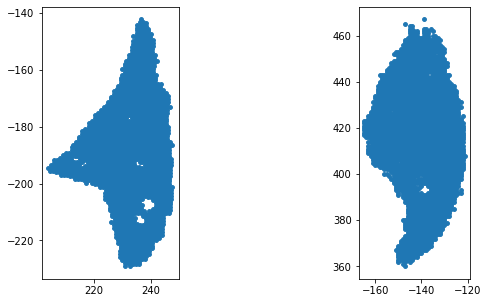

In [3]:
_,axs = plt.subplots(1,2,figsize=[10,5])
axs[0].scatter(adata_1.obsm['spatial'][:,0],adata_1.obsm['spatial'][:,1],s=15)
axs[0].set_aspect(1)
axs[1].scatter(adata_2.obsm['spatial'][:,0],adata_2.obsm['spatial'][:,1],s=15)
axs[1].set_aspect(1)

We'll follow standard transcriptomic data processing steps: first, normalize the count table so each spot has the same total number of transcripts, then perform a log-plus-one transform on the normalized count table.
Dimensionality reduction is performed using principal component analysis, and a neighborhood graph is constructed in PC space. For visualization purposes, the UMAP is also carried out.

In [4]:
sc.pp.normalize_total(adata_1, inplace=True)
sc.pp.log1p(adata_1)
sc.tl.pca(adata_1, svd_solver='arpack',n_comps=50)
sc.pp.neighbors(adata_1)
sc.tl.umap(adata_1)

sc.pp.normalize_total(adata_2, inplace=True)
sc.pp.log1p(adata_2)
sc.tl.pca(adata_2, svd_solver='arpack',n_comps=50)
sc.pp.neighbors(adata_2)
sc.tl.umap(adata_2)

//broad/clearylab/Users/Peter/anaconda3/envs/myEnv/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12030. The TBB threading layer is disabled.
  warnings.warn(problem)


After processing, we cluster spots by gene expression using the Leiden algorithm, intending to identify individual cell types

In [5]:
sc.tl.leiden(adata_1,resolution=0.55)
sc.tl.leiden(adata_2,resolution=0.65)

/local/scratch/46296384.1.interactive/ipykernel_112842/64518427.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_1,resolution=0.55)


We can visualize the spatial distribution of these cell types in the samples. We can also use the UMAP representation to visualize these cell types.

//broad/clearylab/Users/Peter/anaconda3/envs/myEnv/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


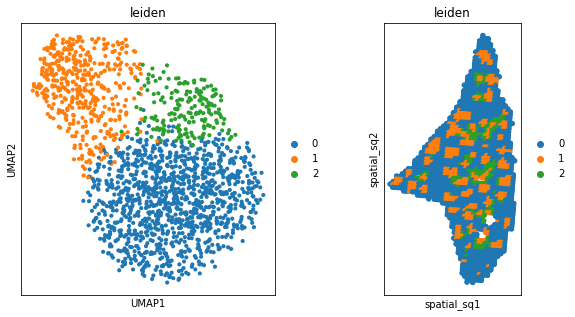

In [6]:
_,axs = plt.subplots(1,2,figsize=[10,5])
sc.pl.umap(adata_1,color=['leiden'],ax=axs[0],show=False)
sq.pl.spatial_scatter(
    adata_1,
    shape=None,
    color='leiden',
    library_id = 'spatial',
    spatial_key = 'spatial_sq',
    ax = axs[1]
)

//broad/clearylab/Users/Peter/anaconda3/envs/myEnv/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


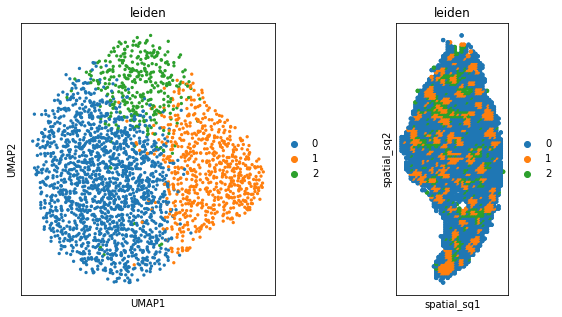

In [7]:
_,axs = plt.subplots(1,2,figsize=[10,5])
sc.pl.umap(adata_2,color=['leiden'],ax=axs[0],show=False)
sq.pl.spatial_scatter(
    adata_2,
    shape=None,
    color='leiden',
    library_id = 'spatial',
    spatial_key='spatial_sq',
    ax = axs[1]
)

In both samples, we identify the spots belonging to cluster 0 as fibroblasts, those belonging to cluster 1 as epithelial cells (mostly developing airways), and those belonging to cluster 2 as smooth muscle cells.

Separately, we have manually segmented the airway structures, and constructed a vector labeling each spot by the airway structure to which it belongs.

In [8]:
struct_labels_1 = np.load('//broad/clearylab/Users/Peter/mosta/structure_labels_lung_14_holes.npy')
struct_labels_2 = np.load('//broad/clearylab/Users/Peter/mosta/structure_labels_lung_15_holes.npy')
adata_1.obs['struct'] = struct_labels_1
adata_2.obs['struct'] = struct_labels_2
adata_1.obs['struct_bool_c'] = pd.Categorical(adata_1.obs['struct']!=0)
adata_2.obs['struct_bool_c'] = pd.Categorical(adata_2.obs['struct']!=0)
adata_1.obs['struct_c'] = pd.Categorical(adata_1.obs['struct'])
adata_2.obs['struct_c'] = pd.Categorical(adata_2.obs['struct'])
adata_1.uns['struct_bool_c_colors'] = ['#DDDDDD','#666666']
adata_2.uns['struct_bool_c_colors'] = ['#DDDDDD','#666666']

We can visualize the spatial distribution of these airways structures:

//broad/clearylab/Users/Peter/anaconda3/envs/myEnv/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


(-167.19999999999996, -118.79999999999997, -354.65, -472.35)

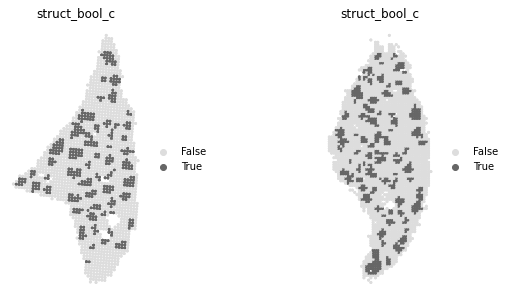

In [9]:
_,axs = plt.subplots(1,2,figsize=[10,5])
sq.pl.spatial_scatter(
    adata_1,
    shape=None,
    color='struct_bool_c',
    library_id='spatial',
    spatial_key='spatial_sq',
    ax=axs[0],
    size=15
)
sq.pl.spatial_scatter(
    adata_2,
    shape=None,
    color='struct_bool_c',
    library_id='spatial',
    spatial_key='spatial_sq',
    ax=axs[1],
    size=15
)
axs[0].axis('off')
axs[1].axis('off')

(-167.19999999999996, -118.79999999999997, -354.65, -472.35)

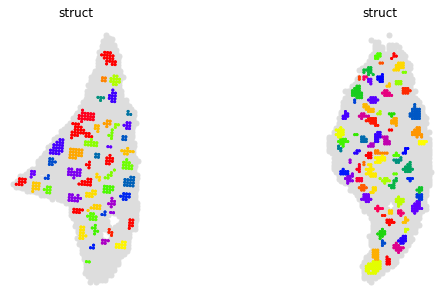

In [10]:
_,axs = plt.subplots(1,2,figsize=[10,5])
axs[0].scatter(adata_1.obsm['spatial_sq'][:,0],adata_1.obsm['spatial_sq'][:,1],s=25,c='#DDDDDD')
sq.pl.spatial_scatter(
    adata_1[adata_1.obs['struct']!=0,:],
    shape=None,
    color='struct',
    library_id='spatial',
    spatial_key='spatial_sq',
    cmap='prism',
    ax=axs[0],
    size=15,
    colorbar=False,
)
axs[1].scatter(adata_2.obsm['spatial_sq'][:,0],adata_2.obsm['spatial_sq'][:,1],s=25,c='#DDDDDD')
sq.pl.spatial_scatter(
    adata_2[adata_2.obs['struct']!=0,:],
    shape=None,
    color='struct',
    library_id='spatial',
    spatial_key='spatial_sq',
    ax=axs[1],
    cmap='prism',
    size=15,
    colorbar=False,
)
axs[0].axis('off')
axs[1].axis('off')

We are interested in the different types of airway, so we isolate the epithelial cells and re-cluster them, intending to separate the proximal and distal airways by gene expression.

In [11]:
adata_1_epithelial = adata_1[adata_1.obs['leiden']=='1',:]
inds_1_epithelial = np.where(adata_1.obs['leiden']=='1')[0]
sc.tl.leiden(adata_1_epithelial,resolution=0.41)


//broad/clearylab/Users/Peter/anaconda3/envs/myEnv/lib/python3.9/site-packages/scanpy/tools/_leiden.py:197: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_added] = pd.Categorical(


This re-clustering separates the epithelial cells into two clusters, and we can visualize their spatial distribution. 

We see that the spots belonging to cluster 0 tend to be surrounded by smooth muscle cells, and those belonging to cluster 1 do not. We infer that cluster 0 corresponds to proximal airway cells, and cluster 1 corresponds to distal airway cells.
From here, we combine the subclustering of epithelial with the broader clustering of fibroblasts and smooth muscle cells.

In [12]:
adata_1.obs['leiden_ep'] = adata_1_epithelial.obs['leiden']
adata_1.obs['leiden_plus'] = adata_1.obs['leiden'].cat.set_categories(['0','1','2','3'])
adata_1.obs['leiden_plus'][adata_1.obs['leiden_ep']=='0'] = '2'
adata_1.obs['leiden_plus'][adata_1.obs['leiden']=='2'] = '3'
adata_1.obs['leiden_plus'][adata_1.obs['leiden_ep']=='1'] = '1'

/local/scratch/46296384.1.interactive/ipykernel_112842/4083709428.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  adata_1.obs['leiden_plus'][adata_1.obs['leiden_ep']=='0'] = '2'
/local/scratch/46296384.1.interactive/ipykernel_112842/4083

We can visualize the spatial distribution of this finer cell-type clustering: 

In [13]:
# We specify the colors to be used in the spatial mapping so that the colors match those in Fig. 1
adata_1.uns['leiden_plus_colors'] = ['#FDD700','#B12625','#4C87C6','#65C7C2']


//broad/clearylab/Users/Peter/anaconda3/envs/myEnv/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


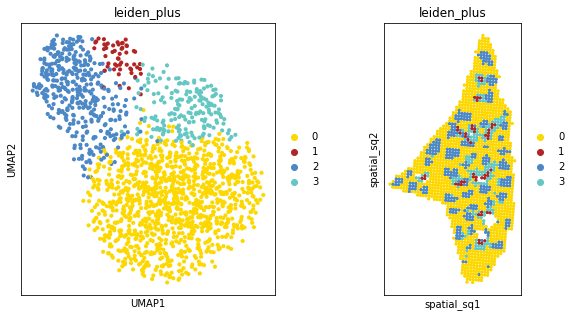

In [14]:
_,axs = plt.subplots(1,2,figsize=[10,5])
sc.pl.umap(adata_1,color='leiden_plus',ax=axs[0],show=False)
sq.pl.spatial_scatter(
    adata_1,
    shape=None,
    color='leiden_plus',
    library_id='spatial',
    spatial_key='spatial_sq',
    size=15,
    ax=axs[1]
)

We again isolate the epithelial cells in the E15.5 dataset, and re-cluster:

In [15]:
adata_2_epithelial = adata_2[adata_2.obs['leiden']=='1',:]
inds_2_epithelial = np.where(adata_2.obs['leiden']=='1')[0]
sc.tl.leiden(adata_2_epithelial,resolution=0.45)

//broad/clearylab/Users/Peter/anaconda3/envs/myEnv/lib/python3.9/site-packages/scanpy/tools/_leiden.py:197: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_added] = pd.Categorical(


In this dataset, the proximal and distal airway cells do not cleanly separate with leiden clustering.

//broad/clearylab/Users/Peter/anaconda3/envs/myEnv/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


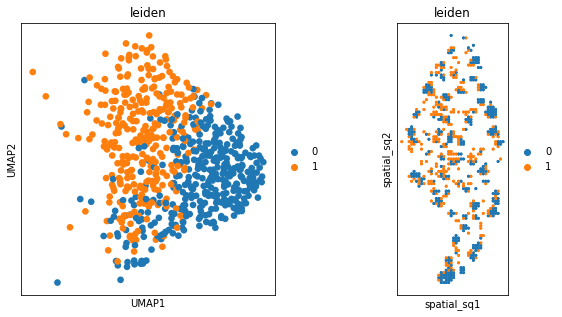

In [16]:
_,axs = plt.subplots(1,2,figsize=[10,5])
sc.pl.umap(adata_2_epithelial,color=['leiden'],ax=axs[0],show=False)
sq.pl.spatial_scatter(
    adata_2_epithelial,
    shape=None,
    color='leiden',
    library_id='spatial',
    spatial_key='spatial_sq',
    size=15,
    ax=axs[1]
)

As an alternative, we identify those airways which are mostly surrounded by smooth muscle cells, and label these as proximal airway cells, and the others as distal airway cells.

In [17]:
# For each airway, compute the proportion of neighboring cells which belong to each of the three top-level cell types
airways_2 = np.unique(adata_2.obs['struct'])
pct_types = np.zeros([len(airways_2),3])
adata_2.obs['layers'] = 0
xy_2 = adata_2.obsm['spatial']
for x in range(len(airways_2)):
    xy_x = xy_2[adata_2.obs['struct']==airways_2[x],:]
    layers_x = neighborhood_n_layers(xy_x,xy_2,1,10)
    inds_x = np.where(layers_x==1)[0]
    for y in range(3):
        pct_types[x,y] = len(np.where(adata_2[inds_x,:].obs['leiden']==str(y))[0])/len(inds_x)

In [18]:
# Identify the airways in which more than 40% of the neighboring cells are smooth muscle cells
airways_sm_2 = airways_2[np.where(pct_types[:,2]>0.4)[0]]
adata_2_epithelial.obs['a_sm'] = pd.Categorical(adata_2_epithelial.obs['struct'].isin(airways_sm_2))

We again combine the subdivided epithelial labels with the broader fibroblast and smooth muscle cell labels.

In [19]:
adata_2.obs['a_sm_ep'] = adata_2_epithelial.obs['a_sm']
adata_2.obs['leiden_plus'] = adata_2.obs['leiden'].cat.set_categories(['0','1','2','3'])
adata_2.obs['leiden_plus'][adata_2.obs['a_sm_ep']==False] = '2'
adata_2.obs['leiden_plus'][adata_2.obs['leiden']=='2'] = '3'
adata_2.obs['leiden_plus'][adata_2.obs['a_sm_ep']==True] = '1'

/local/scratch/46296384.1.interactive/ipykernel_112842/3102273933.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  adata_2.obs['leiden_plus'][adata_2.obs['a_sm_ep']==False] = '2'
/local/scratch/46296384.1.interactive/ipykernel_112842/3102

We can visualize the spatial distribution of these finer-grained cell type labels in the E15.5 dataset

In [20]:
adata_2.uns['leiden_plus_colors'] = ['#FDD700','#B12625','#4C87C6','#65C7C2']

//broad/clearylab/Users/Peter/anaconda3/envs/myEnv/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


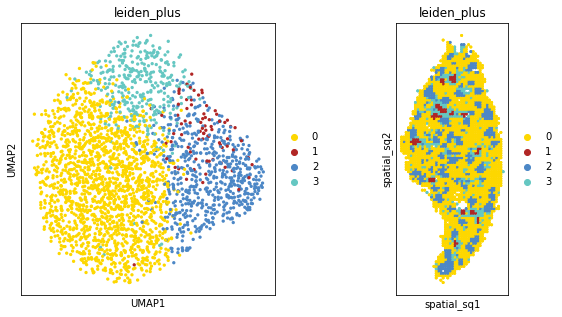

In [21]:
_,axs = plt.subplots(1,2,figsize=[10,5])
sc.pl.umap(adata_2,color=['leiden_plus'],ax=axs[0],show=False)
sq.pl.spatial_scatter(
    adata_2,
    shape=None,
    color=['leiden_plus'],
    library_id='spatial',
    spatial_key='spatial_sq',
    size=15,
    figsize=[10,10],
    ax=axs[1]
)

Finally, we save the processed anndata objects for future use.

In [22]:
adata_1.write('lung_14_2_processed.h5ad')
adata_2.write('lung_15_4_processed.h5ad')